# Introduction


**What?** Autoregression models for forecasting



# What is autoregression?


- Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. 
- It is a very simple idea that can result in accurate forecasts on a range of time series problems.



# Import modules 

In [1]:
from pandas import read_csv
from matplotlib import pyplot, rcParams
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Import dataset

In [2]:
series = read_csv('../../DATASETS/daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# Quick Check for Autocorrelation

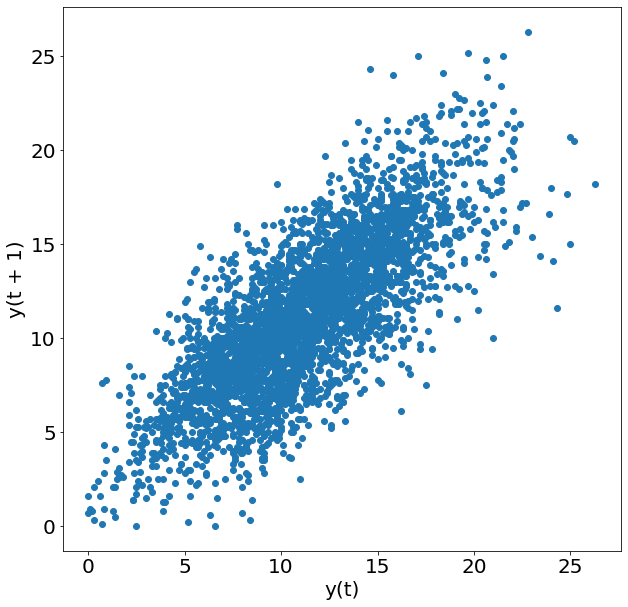

In [3]:
rcParams['figure.figsize'] = 10, 10
rcParams['font.size'] = 20
lag_plot(series);


- Running the example plots the temperature data (t) on the x-axis against the temperature on the previous day (t-1) on the y-axis. 
- We can see a large ball of observations along a diagonal line of the plot. It clearly shows a relationship or some correlation. 
- Correlation can be calculated easily using the corr() function on the DataFrame of the lagged dataset.



In [4]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1) 
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

           t      t+1
t    1.00000  0.77487
t+1  0.77487  1.00000


    
- This is a good confirmation for the plot above. It shows a strong positive correlation (0.77) between the observationv and the lag=1 value. 
- This is good for one-off checks, but tedious if we want to check a large number of lag variables in our time series. 
- Next, we will look at a scaled-up version of this approach.  



# Autocorrelation Plots


- We can plot the correlation coefficient for each lag variable. This can very quickly give an idea of which lag 
variables may be good candidates for use in a predictive model and how the relationship between the observation 
and its historic values changes over time.

- The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation
values. Correlation values above these lines are more significant than those below the line, providing a threshold
or cutoff for selecting more relevant lag values. 

- Running the example shows the swing in positive and negative correlation as the temperature values change across 
summer and winter seasons each previous year. 
- We can also use a line plot using **plot_acf**.



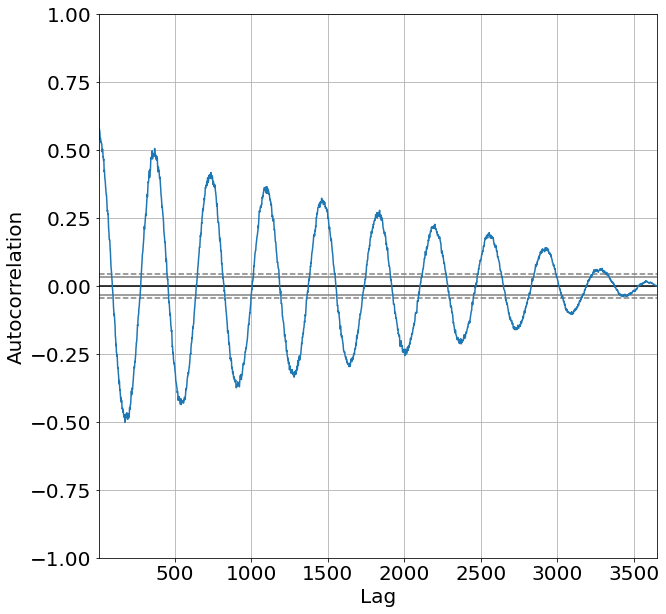

In [5]:
autocorrelation_plot(series)
pyplot.show()

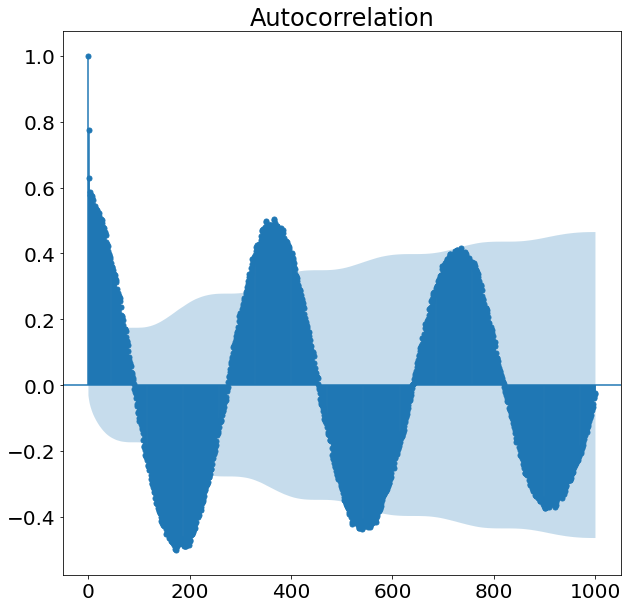

In [6]:
plot_acf(series, lags = 1000)
pyplot.show()

In [7]:
# Persistence model - getting a baseline model


- When predicting the value at time "t+1", it simply uses the value at time "t" as its prediction (often referred to as the **persistence model**).
- It can be used to provide a BASELINE of performance for the problem that we can use for COMPARISON with an autoregression model.



In [8]:
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1) 
dataframe.columns = ['t', 't+1']

# split into train and test sets, We'd like to predict the last 7 days
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

rmse = sqrt(mean_squared_error(test_y, predictions)) 
print('Baseline performance on the test set RMSE: %.3f' % rmse)

Baseline performance on the test set RMSE: 1.850


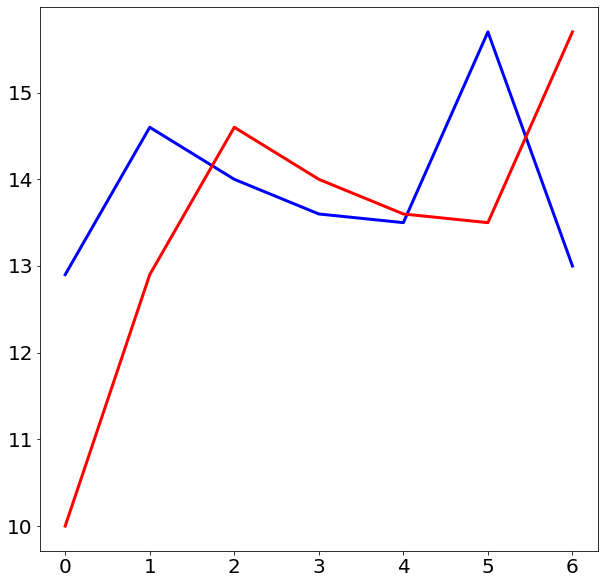

In [9]:
# plot predictions vs expected
pyplot.plot(test_y, lw = 3, c = "b")
pyplot.plot(predictions, lw = 3, c = 'red')
pyplot.show()

# Autoregression Model


- An autoregression model is a **linear** regression model that uses lagged variables as input variables.
- A plot of the expected vs the predicted values is made. The forecast does look pretty good (about 1 degree Celsius out each day), with big deviation on day 5.



In [10]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression

"""
To silence this warning and continue using AR until it is removed, use:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)
"""

model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) 

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i])) 

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Lag: 29
Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


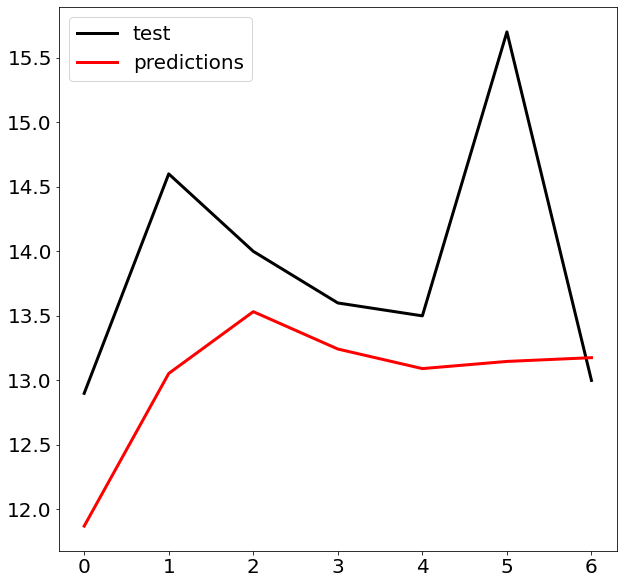

In [11]:
# plot results
pyplot.plot(test, c = "k", lw = 3, label = "test") 
pyplot.plot(predictions, c = 'r', lw = 3, label = "predictions") 
pyplot.legend()
pyplot.show()


- The Statsmodels API does not make it easy to update the model as new observations become available. 
- One way would be to re-train the AR model each day as new observations become available, and that may be a valid approach, if not computationally expensive. 
- An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be  retrieved from the model and used in the regression equation to come up with new forecasts.



In [12]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


In [13]:
"""
We can see a small improvement in the forecast when comparing the RMSE scores from 1.225 to 1.204.
"""

'\nWe can see a small improvement in the forecast when comparing the RMSE scores from 1.225 to 1.204.\n'

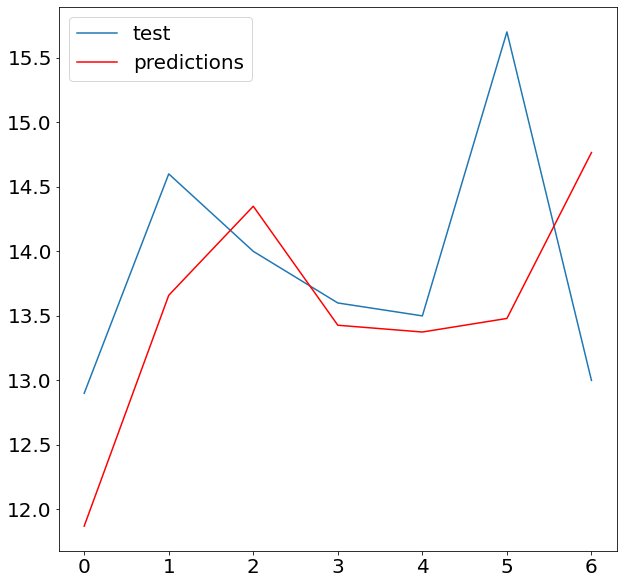

In [14]:
# plot results
pyplot.plot(test, label = "test") 
pyplot.plot(predictions, color='red', label = "predictions") 
pyplot.legend()
pyplot.show()

# References


- https://machinelearningmastery.com/?s=time+series&post_type=post&submit=Search

